In [2]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

from ase.build import bulk
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

import pickle

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [8]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [4]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "!    total energy" in match]
    KS_te = str(k).split()[4]
    KS_TE.append(float(KS_te)) 
ks_te = np.asarray(KS_TE)

In [5]:
rho0 = np.load('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/rho0_dTE.npy')

In [9]:
%%notify
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho0)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
ENERGY = []
VOLUME = []
for n in np.arange(0, 30, 1):
        i = int(n)
        
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)
        ions.set_charges(4)
        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)

        energy = evaluator.Energy(rho=rho, ions=ions)
        vol=ions.get_volume()

        ENERGY.append(energy)
        VOLUME.append(vol)

setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -1.454472427299E+01     -1.454472E+01   4.864010E+00    1       1       5.386806E-02    
1       -1.554540503022E+01     -1.000681E+00   2.773892E-01    4       2       7.594109E-02    
2       -1.556261578540E+01     -1.721076E-02   2.040266E-02    4       1       9.571815E-02    
3       -1.556501824555E+01     -2.402460E-03   1.273339E-03    6       1       1.244640E-01    
4       -1.556508859176E+01     -7.034621E-05   8.545767E-05    4       1       1.500480E-01    
5       -1.556509714691E+01     -8.555150E-06   8.476070E-06    5       1       1.573400E-01    
6       -1.556509790073E+01     -7.538129E-07   6.889483E-07    6       1       1.908410E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.7719862998571706
Chemical potential (eV)  : 21.006817210936394
setting key: Si

<IPython.core.display.Javascript object>

1       -7.388094557867E-01     -1.858648E+00   1.351876E+00    13      2       3.061600E-01    
2       -8.206745316385E-01     -8.186508E-02   1.161282E-01    4       1       3.770270E-01    
3       -8.514448711560E-01     -3.077034E-02   8.708155E-03    12      2       5.530453E-01    
4       -8.522277354601E-01     -7.828643E-04   5.713952E-04    5       1       6.326158E-01    
5       -8.522608302629E-01     -3.309480E-05   4.382644E-05    4       1       6.976533E-01    
6       -8.522692343139E-01     -8.404051E-06   3.984194E-06    10      1       8.339186E-01    
7       -8.522697357945E-01     -5.014806E-07   3.009425E-07    8       1       9.938416E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05057271859621478
Chemical potential (eV)  : 1.3761536367134506
setting key: Si -> /.../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.949408264520

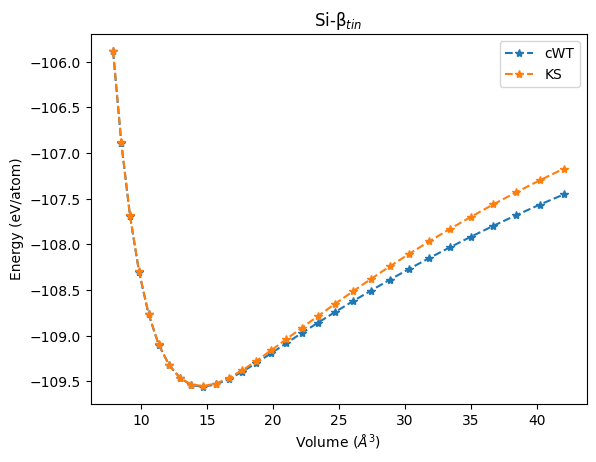

In [7]:
plt.plot(np.asarray(VOLUME)*0.529177**3/4,(np.asarray(ENERGY))*27.211407/4,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/4, np.asarray(KS_TE)*27.211407/8,'*--')
plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si-\u03B2$_{tin}$')
plt.legend(['cWT','KS'])